# Building decision trees for classification

We will now build a decision tree for a churn dataset. In Python, only an implementation of CART is available, however, it is possible to select the splitting criterion (which is Gini by default).

Let's first import the data.

## Dataset

In [42]:
%matplotlib inline

import pandas as pd
import numpy as np

df = pd.read_csv('churn_ibm.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We see various variables, both demographic ones (Partner (Yes/No), tenure (length of contract), gender, etc.), as well as service-related variables (DeviceProtection, PaymentMethod, Contact, MonthlyCharges, etc.). All variables are relatively self-explanatory.

Let's split the data into independent and dependent parts (we don't use the customerID to predict and drop it):

In [43]:
y = df['Churn']
X = df.drop(['Churn', 'customerID'],axis=1)

Something else we should consider is that the CART implementation in Python can only deal with numeric variables. Let's check whether we need to convert variables:

In [44]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

It appears there are a lot of categorical variables of type 'object'. Let's convert those:

In [45]:
for column in X.columns:
    if X[column].dtype == np.object:
        print('Converting ', column)
        X = pd.concat([X,pd.get_dummies(X[column], prefix = column, drop_first=True)],axis=1).drop([column],axis=1)

Converting  gender
Converting  Partner
Converting  Dependents
Converting  PhoneService
Converting  MultipleLines
Converting  InternetService
Converting  OnlineSecurity
Converting  OnlineBackup
Converting  DeviceProtection
Converting  TechSupport
Converting  StreamingTV
Converting  StreamingMovies
Converting  Contract
Converting  PaperlessBilling
Converting  PaymentMethod


<ipython-input-45-9b11a1b33533>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if X[column].dtype == np.object:


The dependent variable is also still categorical. This is fine for CART, but can't be used to calcualte the AUC later. We convert it as well:

In [46]:
y = pd.get_dummies(y, prefix='churn', drop_first=True)
y.head()

,churn_Yes
0,0
1,0
2,1
3,0
4,1


## Building the tree

We can very easily calculate a decision tree without changing any parameters using a training and test set:

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

# We generate the predictions, which generate the predicted class
prediction = decision_tree.predict(X_test)
# We also generate the probabilities for each class to calculate the AUC
# In case of a decision tree, this is the number of samples of a class in a leaf node
# over all samples in the leaf node, which often returns few thresholds
prediction_proba = decision_tree.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test,prediction))
# prediction_proba returns the result of both the 0 and 1 label, we use the latter
print('AUC:', roc_auc_score(y_test,prediction_proba[:,1]))

Accuracy: 0.7402843601895734
AUC: 0.6637335650261985


Our tree has the following size:

In [48]:
print('Number of nodes:', decision_tree.tree_.node_count)

Number of nodes: 1971


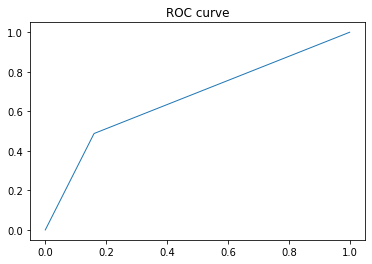

In [49]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, prediction_proba[:,1])
plt.plot(fpr, tpr, lw=1, alpha=1,label='ROC')
plt.title('ROC curve')
plt.show()

We can also change the parameters, using a tree with a max depth of 3, and a minimum of 10 samples per leaf. This time, we also use entropy/information gain instead of Gini index:

In [54]:
decision_tree2 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,criterion='entropy')
decision_tree2.fit(X_train,y_train)
prediction = decision_tree2.predict(X_test)

print('Accuracy:', accuracy_score(y_test,prediction))
print('AUC:',roc_auc_score(y_test,prediction))
print('Number of noes:', decision_tree2.tree_.node_count)


Accuracy: 0.7701421800947867
AUC: 0.73198913053115
Number of noes: 15


Both our accuracy and AUC are up, possibly due to less overfitting with having a smaller tree with less leaves.

## Visualising the tree

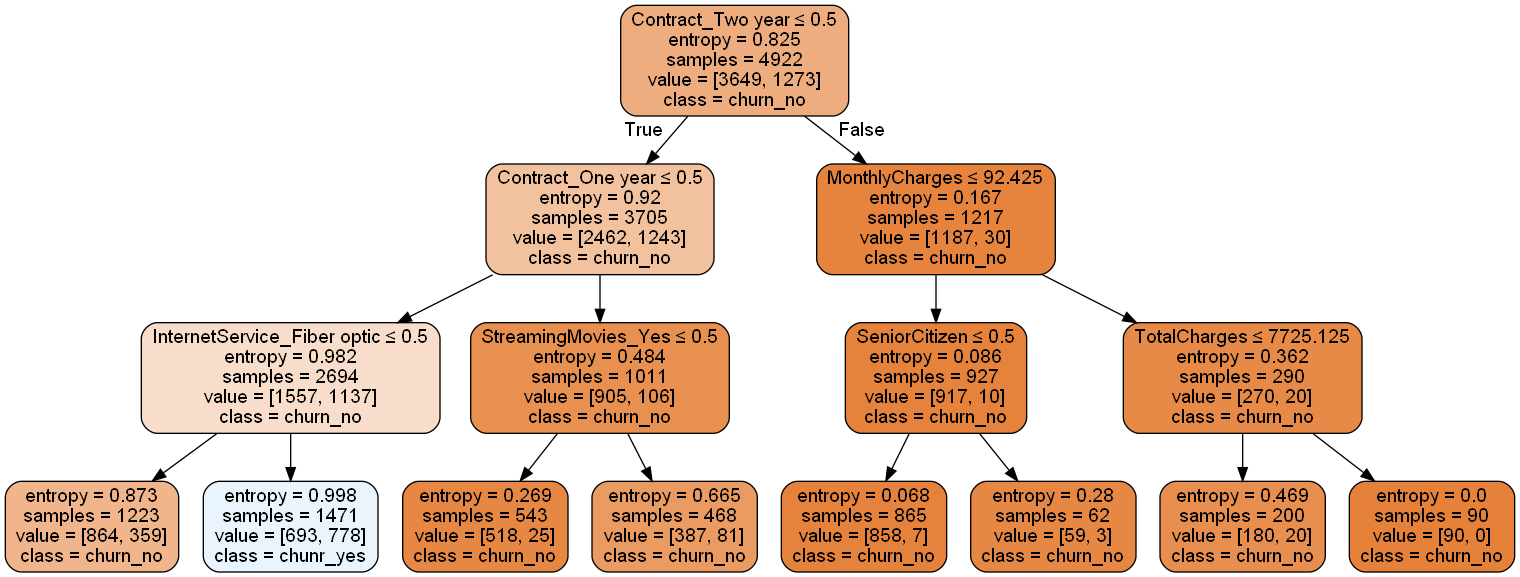

In [57]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()

export_graphviz(decision_tree2, out_file=dot_data, filled=True, rounded=True, class_names=['churn_no','chunr_yes'],
special_characters=True,feature_names=X.columns)

# import and display the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())